<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/SVR_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective
The goal of this study is to apply Holt-Winters Technique to predict monthly crude oil price. 

###Mount Google Drive

In [328]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load the libraries

In [15]:
import warnings
from math import sqrt
import plotly.express as px 
import matplotlib.dates as mdates
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.7.0


###Write Functions to Facilitate Model Evaluation

In [6]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


###Load the Data

In [127]:
#reading the csv file into pandas data frame
df_cl = pd.read_csv("/content/gdrive/MyDrive/df_cl.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [128]:
df_cl.head()

,Unnamed: 0,Month,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
0,0,2002-02-01,323,455,468.0,844.0,578.0,423.45,28.67
1,1,2002-03-01,345,546,485.0,799.0,557.0,415.85,24.49
2,2,2002-04-01,362,595,466.0,718.0,552.0,410.77,22.06
3,3,2002-05-01,376,636,442.0,614.0,574.0,414.82,21.64
4,4,2002-06-01,383,738,429.0,619.0,595.0,451.04,22.30


In [129]:
del df_cl['Unnamed: 0']
df_cl.head()

,Month,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
0,2002-02-01,323,455,468.0,844.0,578.0,423.45,28.67
1,2002-03-01,345,546,485.0,799.0,557.0,415.85,24.49
2,2002-04-01,362,595,466.0,718.0,552.0,410.77,22.06
3,2002-05-01,376,636,442.0,614.0,574.0,414.82,21.64
4,2002-06-01,383,738,429.0,619.0,595.0,451.04,22.30


####Plot the Multivariate Time Series

In [130]:
df_wide = df_cl
df_long = pd.melt(df_wide, id_vars=['Month'], value_vars=['cpo_pri',	'cno_pri',	'sbo_pri','pno_pri','sfo_pri','rps_pri','wti_spri'])

# plotly 
fig = px.line(df_long, x='Month', y='value', color='variable')
fig.show()

In [131]:
df_cl.head()

,Month,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
0,2002-02-01,323,455,468.0,844.0,578.0,423.45,28.67
1,2002-03-01,345,546,485.0,799.0,557.0,415.85,24.49
2,2002-04-01,362,595,466.0,718.0,552.0,410.77,22.06
3,2002-05-01,376,636,442.0,614.0,574.0,414.82,21.64
4,2002-06-01,383,738,429.0,619.0,595.0,451.04,22.30


In [132]:
df_cl['Month'] = df_cl['Month'].apply(pd.to_datetime)
df_cl['index'] = pd.DataFrame(date_rng, columns=['Month'])

In [133]:
df_cl.head()

,Month,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri,index
0,2002-02-01,323,455,468.0,844.0,578.0,423.45,28.67,2002-02-28
1,2002-03-01,345,546,485.0,799.0,557.0,415.85,24.49,2002-03-31
2,2002-04-01,362,595,466.0,718.0,552.0,410.77,22.06,2002-04-30
3,2002-05-01,376,636,442.0,614.0,574.0,414.82,21.64,2002-05-31
4,2002-06-01,383,738,429.0,619.0,595.0,451.04,22.30,2002-06-30


In [134]:
del df_cl['Month']
df_cl.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri,index
0,323,455,468.0,844.0,578.0,423.45,28.67,2002-02-28
1,345,546,485.0,799.0,557.0,415.85,24.49,2002-03-31
2,362,595,466.0,718.0,552.0,410.77,22.06,2002-04-30
3,376,636,442.0,614.0,574.0,414.82,21.64,2002-05-31
4,383,738,429.0,619.0,595.0,451.04,22.30,2002-06-30


In [135]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cpo_pri   230 non-null    int64         
 1   cno_pri   230 non-null    int64         
 2   sbo_pri   230 non-null    float64       
 3   pno_pri   230 non-null    float64       
 4   sfo_pri   230 non-null    float64       
 5   rps_pri   230 non-null    float64       
 6   wti_spri  230 non-null    float64       
 7   index     230 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 14.5 KB


In [136]:
df_cl.set_index('index',inplace=True)

In [174]:
df_cl.head() 

,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
index,,,,,,,
2002-02-28,323,455,468.0,844.0,578.0,423.45,28.67
2002-03-31,345,546,485.0,799.0,557.0,415.85,24.49
2002-04-30,362,595,466.0,718.0,552.0,410.77,22.06
2002-05-31,376,636,442.0,614.0,574.0,414.82,21.64
2002-06-30,383,738,429.0,619.0,595.0,451.04,22.30


In [303]:
# We split our dataset to be able to evaluate our models
split_date = '2017-06'
df_training = df_cl.loc[df_cl.index <= split_date]
df_test = df_cl.loc[df_cl.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [304]:
df_training.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
index,,,,,,,
2002-02-28,323,455,468.0,844.0,578.0,423.45,28.67
2002-03-31,345,546,485.0,799.0,557.0,415.85,24.49
2002-04-30,362,595,466.0,718.0,552.0,410.77,22.06
2002-05-31,376,636,442.0,614.0,574.0,414.82,21.64
2002-06-30,383,738,429.0,619.0,595.0,451.04,22.30


In [305]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [306]:
x = df_cl[['cno_pri', 'sbo_pri', 'pno_pri', 'sfo_pri', 'rps_pri', 'wti_spri']]
y = df_cl[['cpo_pri']]

In [307]:
x.reset_index(drop=True)

,cno_pri,sbo_pri,pno_pri,sfo_pri,rps_pri,wti_spri
0,455,468.00,844.00,578.00,423.45,28.67
1,546,485.00,799.00,557.00,415.85,24.49
2,595,466.00,718.00,552.00,410.77,22.06
3,636,442.00,614.00,574.00,414.82,21.64
4,738,429.00,619.00,595.00,451.04,22.30
...,...,...,...,...,...,...
225,993,860.28,1366.87,1667.82,1047.78,34.03
226,1031,910.82,1366.87,1680.32,1097.63,35.50
227,1170,997.62,1383.90,1375.09,1138.24,35.81
228,1275,1035.26,1426.71,1359.46,1272.13,33.59


In [308]:
y.reset_index(drop=True)

,cpo_pri
0,323
1,345
2,362
3,376
4,383
...,...
225,826
226,844
227,944
228,949


###Apply Scaling Function

In [309]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale = scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler()
MinMaxScaler()


###Split Data into Train, Test Sets:

In [310]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)

In [311]:
X_test

array([[0.10742496, 0.20348963, 0.26926624, 0.27296937, 0.4849252 ,
        0.78186689],
       [1.        , 1.        , 0.94934537, 0.11318242, 0.36374258,
        0.60095883],
       [0.03554502, 0.08315509, 0.10593616, 0.685253  , 0.75591605,
        0.79413424],
       [0.38230648, 0.34619113, 0.26443024, 0.17046605, 0.39335032,
        0.44007332],
       [0.13744076, 0.20745512, 0.36060327, 0.27247004, 0.51725072,
        0.80992668],
       [0.33096367, 0.10177285, 0.1537546 , 0.26231691, 0.41499945,
        0.45812183],
       [0.33254344, 0.48876445, 0.31815696, 0.22246338, 0.32672655,
        0.47433728],
       [0.23775671, 0.26845955, 0.26592608, 0.27097204, 0.94333297,
        0.66990976],
       [0.40521327, 0.49852997, 0.3889705 , 0.46452064, 0.40592324,
        0.43880429],
       [0.23459716, 0.21793362, 0.25422211, 0.21486684, 0.33675102,
        0.34574168],
       [0.15955766, 0.25745231, 0.42741183, 0.20689081, 0.50730245,
        0.82473209],
       [0.03475513, 0

####Apply Grid Search to SVR Model

In [312]:
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear'],
              'epsilon': [1e-4, 1e-3]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, scoring=scorer, refit = True, verbose =3)
grid.fit(X_train,np.ravel(y_train))
svr_gpred = grid.predict(X_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 2/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 3/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 4/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 5/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 6/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 7/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 8/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 9/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.003 total time=   0.0s
[CV 10/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 1/10] END C=0.1, epsil

In [313]:
testY = scaler_y.inverse_transform(y_test)

In [314]:
testY2 = pd.DataFrame(testY, columns = ['Predictions'])

In [315]:
testY2.head()

,Predictions
0,443.0
1,1293.0
2,323.0
3,661.0
4,466.0


In [317]:
svr_gprediction = np.reshape(svr_gpred, (-1,1))

In [318]:
svr_gprediction = scaler_y.inverse_transform(svr_gprediction)

In [319]:
svr_prediction = pd.DataFrame(svr_gprediction, columns = ['Predictions'])

In [320]:
svr_prediction

,Predictions
0,456.138306
1,1414.139573
2,298.997599
3,686.888433
4,462.643643
5,379.097751
6,738.608843
7,585.183222
8,795.351914
9,474.175463


####Plot train, test and forecast

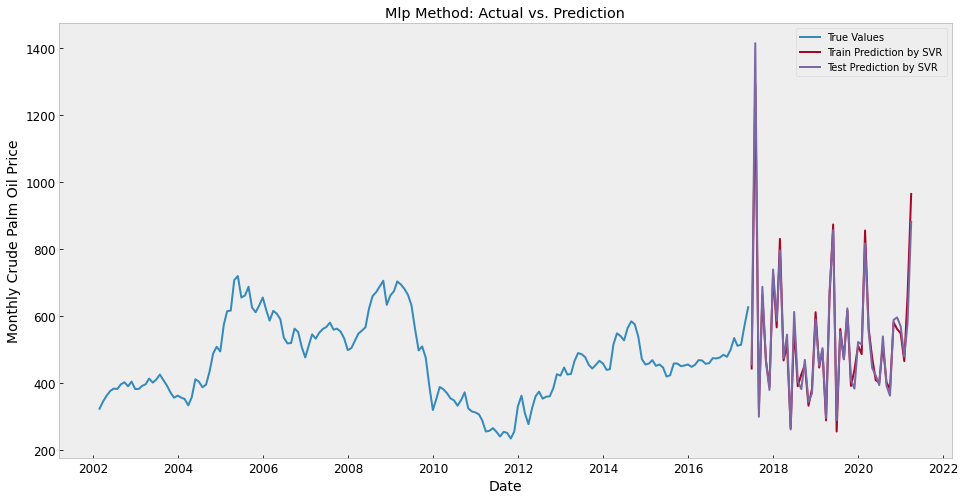

In [323]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, testY2,  label = 'Test')
plt.plot(df_test.index, svr_prediction,label = 'SVR Prediction')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####SVR Prediction Plot Zoomed-In

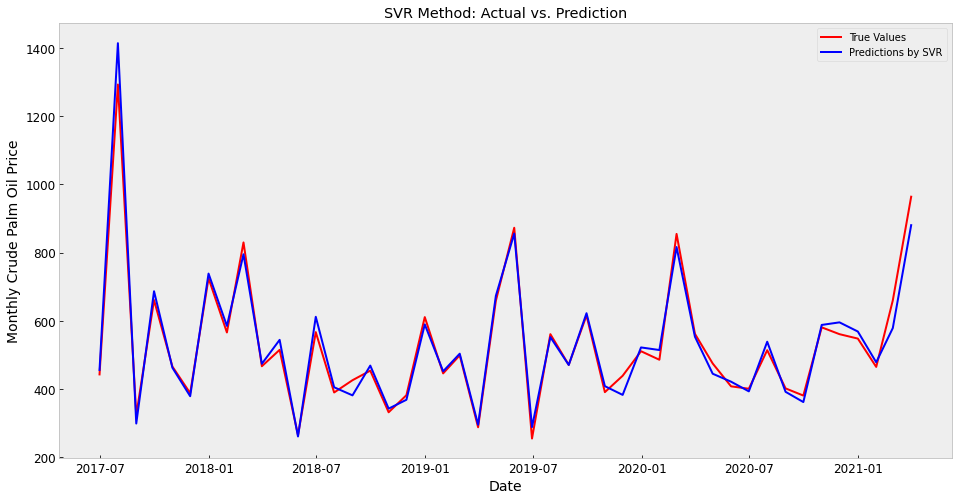

In [324]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.index,  svr_prediction, color = 'blue',label = 'SVR Prediction')
plt.legend(['True Values', 'Predictions by SVR', 'SVR Prediction'],loc='best')
plt.title('SVR Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####Evaluate SVR Model Accuracy

In [327]:
MAE_svr = mean_absolute_error(testY2, svr_prediction)
print('MAE value of the SVR Model is:', MAE_svr)

MDA_svr = mda(testY2, svr_prediction)
print('MDA value of the SVR Model is:', *MDA_svr)

MAPE_svr = mean_absolute_percentage_error(testY2, svr_prediction)
print('MAPE value of the SVR Model is:', MAPE_svr)


RMSE_svr = mean_squared_error(testY2,svr_prediction, squared=False)
print('RMSE value of the SVR Model is:', RMSE_svr)


MSE_svr = mean_squared_error(testY2,svr_prediction)
print('MSE value of the SVR Model is:', MSE_svr)

MAE value of the SVR Model is: 23.347351303880448
MDA value of the SVR Model is: 0.9565217391304348
MAPE value of the SVR Model is: 4.25461054287112
RMSE value of the SVR Model is: 32.79707621249276
MSE value of the SVR Model is: 1075.6482080880587
